# Text Classification - Sarcasm Detection

**Problem:**
Detection of sarcasm from tweets. I got set of training list of tweets and the context for each tweet. using the state of art text classification practices I need to generate a model to solve the problem.

**Approach:** 
Using Tensorflow2 and Keras deep learning API with Pretrained BERT to generate a model. 


**Results:**
I have tried multiple models with various combination with BERT,LSTM and finally following model gave me better results. 

Below are a validation results for 500 tweets, Validated from the generated trained model(Note: results varies by training epochs).

              precision    recall  f1-score   support
     SARCASM       0.79      0.80      0.80       250
     NOT_SARCASM   0.80      0.79      0.80       250
     ------------------------------------------------
     accuracy                          0.80       500
     macro avg     0.80      0.80      0.80       500
     weighted avg  0.80      0.80      0.80       500



Using Google Colab, Enable the GPU hardware accelator for faster training.

Note: to enable GPU, goto Edit -> Network Settings -> set the hardware accelarator to GPU.



In [4]:
!nvidia-smi

Sun Dec 13 19:41:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu >> /dev/null
!pip install --upgrade grpcio >> /dev/null
!pip install tqdm >> /dev/null
!pip install bert-for-tf2 >> /dev/null
!pip install sentencepiece >> /dev/null

In [5]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow import keras

import bert

from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report

#Preprocessing
Load Bert Pretrained models. https://github.com/google-research/bert


I have choosed uncases L-12 H-768 A-12 model available at https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip


In [6]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip
os.makedirs("model", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ model

bert_model_name="uncased_L-12_H-768_A-12"

bert_dir = os.path.join("model/", bert_model_name)
bert_file = os.path.join(bert_dir, "bert_model.ckpt")
bert_config = os.path.join(bert_dir, "bert_config.json")


--2020-12-13 19:42:16--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.20.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   123MB/s    in 3.2s    

2020-12-13 19:42:20 (123 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


# Data

Load the train and test data, for ease of doing i have splitted train data to train and validation data. we can do it using the sklearn "train_test_split", but for now i have handled it manually for couple of reason. 

*   I want to keep the validation set separate from the training list. so that i can validate the overal precision and recal after training
*   I dont want to get random set very time, to avoid random results when I run the model multiple times.

In [7]:

train = pd.read_json("sample_data/train.jsonl",lines=True)
valid = pd.read_json("sample_data/valid.jsonl",lines=True)
test = pd.read_json("sample_data/test.jsonl",lines=True)



Below are some methods used to clean up the text in the training list.


In [8]:
def preprocess_sentence(text):
    text = str(text).lower()
    text = re.sub(r"<url>", "", text)
    text=re.sub(r'@\w+', '',text)
    text=re.sub(r'#\w+', '',text)
    return text;

Lets see the training data categories in a graphical view.

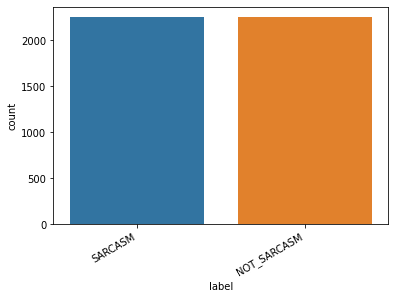

In [9]:
dataCategoriesChart = sns.countplot(x=train.label)
dataCategoriesChart.set_xticklabels(dataCategoriesChart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Model
Below is a scarcasm detection as class.

In [10]:
class ScarcasmDetectionData:
  DATA_COLUMN = "response"
  CONTEXT_COLUMN = "context"
  LABEL_COLUMN = "label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[ScarcasmDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label, context = row[ScarcasmDetectionData.DATA_COLUMN], row[ScarcasmDetectionData.LABEL_COLUMN], row[ScarcasmDetectionData.CONTEXT_COLUMN]
      tokens = self.tokenizer.tokenize(preprocess_sentence(text))
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

Load the tokenizer for the bert pretrained model.

In [11]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_dir, "vocab.txt"))

In [ ]:
tokenizer.tokenize(preprocess_sentence("I can't wait to visiting my place again!"))

In [ ]:
tokens = tokenizer.tokenize(preprocess_sentence("I can't wait to visiting my place again!"))
tokenizer.convert_tokens_to_ids(tokens)

Below is the method to create our model.

*   Here we used Bert model, created using *BertModelLayer* and generate a bert matrix with max sequence length.
*   Add dropouts layers with tanh activation and dense layer with sigmoid activation.
*   Build the modell with max sequence length.
*   then load the stock weights.

---



In [12]:

def create_model(max_seq_len, bert_file):

  with tf.io.gfile.GFile(bert_config, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
  
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=250, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=2, activation="sigmoid")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
 
  model.build(input_shape=(None, max_seq_len))
  model.summary()
  load_stock_weights(bert, bert_file)
        
  return model

Get the summary of the information we have till now.

In [13]:
classes = train.label.unique().tolist()
data = ScarcasmDetectionData(train, valid, tokenizer, classes, max_seq_len=100)


4500it [00:01, 2280.08it/s]
500it [00:00, 2095.92it/s]


In [15]:
model = create_model(data.max_seq_len, bert_file)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 85)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 85, 768)           108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               192250    
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

Compile the model with Adam Optimizer by using SparseCategoricalCrossEntropy and SparseCategoricalAccracy metrics.

In [16]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5,epsilon=1e-06)
model.compile(
  optimizer=optimizer,
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [17]:
# Plot the Epoch-Loss chart.
def plotLossEpochs(trainedModel):
  gca = plt.figure().gca()
  gca.xaxis.set_major_locator(MaxNLocator(integer=True))
  gca.plot(trainedModel.history['loss'])
  gca.plot(trainedModel.history['val_loss'])

  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'])
  plt.title('Loss over training epochs')
  plt.show();

# Plot the Epoch-Accuracy chart.
def plotAccuracyEpochs(trainedModel):
  gca = plt.figure().gca()
  gca.xaxis.set_major_locator(MaxNLocator(integer=True))
  gca.plot(trainedModel.history['acc'])
  gca.plot(trainedModel.history['val_acc'])

  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'])
  plt.title('Accuracy over training epochs')
  plt.show();

# Training method
def training_set(batch_size, epochs, cp_callback):
  return model.fit(
    x=data.train_x, 
    y=data.train_y,
    validation_split=0.1,
    batch_size=batch_size,
    shuffle=True,
    epochs=epochs,
    callbacks=[cp_callback]
  )



Generate an iterative training with variable batch size and epochs and draw charts.

Epoch 1/5
254/254 [==============================] - ETA: 0s - loss: 0.6288 - acc: 0.6538
Epoch 00001: saving model to model/bert_faq.ckpt
254/254 [==============================] - 131s 515ms/step - loss: 0.6288 - acc: 0.6538 - val_loss: 0.5952 - val_acc: 0.6978
Epoch 2/5
254/254 [==============================] - ETA: 0s - loss: 0.5400 - acc: 0.7669
Epoch 00002: saving model to model/bert_faq.ckpt
254/254 [==============================] - 131s 516ms/step - loss: 0.5400 - acc: 0.7669 - val_loss: 0.5977 - val_acc: 0.7000
Epoch 3/5
254/254 [==============================] - ETA: 0s - loss: 0.5003 - acc: 0.8089
Epoch 00003: saving model to model/bert_faq.ckpt
254/254 [==============================] - 131s 516ms/step - loss: 0.5003 - acc: 0.8089 - val_loss: 0.5884 - val_acc: 0.7000
Epoch 4/5
254/254 [==============================] - ETA: 0s - loss: 0.4599 - acc: 0.8499
Epoch 00004: saving model to model/bert_faq.ckpt
254/254 [==============================] - 131s 516ms/step - loss: 0.

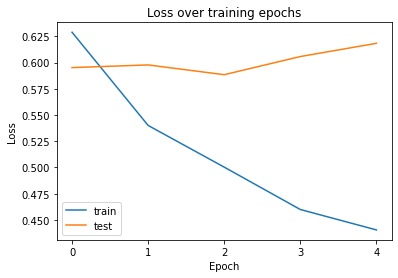

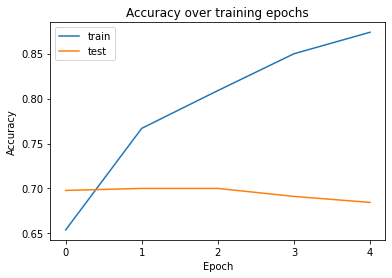

Epoch 1/3
127/127 [==============================] - ETA: 0s - loss: 0.4124 - acc: 0.9002
Epoch 00001: saving model to model/bert_faq.ckpt
127/127 [==============================] - 104s 822ms/step - loss: 0.4124 - acc: 0.9002 - val_loss: 0.6325 - val_acc: 0.6711
Epoch 2/3
127/127 [==============================] - ETA: 0s - loss: 0.4057 - acc: 0.9077
Epoch 00002: saving model to model/bert_faq.ckpt
127/127 [==============================] - 104s 818ms/step - loss: 0.4057 - acc: 0.9077 - val_loss: 0.6050 - val_acc: 0.6956
Epoch 3/3
127/127 [==============================] - ETA: 0s - loss: 0.3978 - acc: 0.9153
Epoch 00003: saving model to model/bert_faq.ckpt
127/127 [==============================] - 104s 818ms/step - loss: 0.3978 - acc: 0.9153 - val_loss: 0.5936 - val_acc: 0.7067


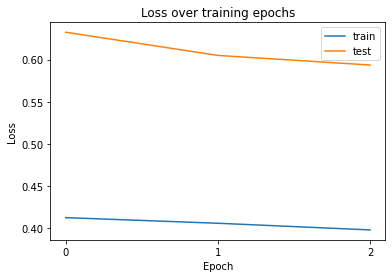

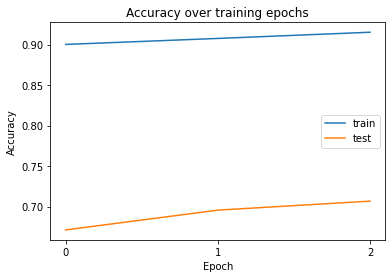

Epoch 1/3
64/64 [==============================] - ETA: 0s - loss: 0.3855 - acc: 0.9286
Epoch 00001: saving model to model/bert_faq.ckpt
64/64 [==============================] - 92s 1s/step - loss: 0.3855 - acc: 0.9286 - val_loss: 0.6129 - val_acc: 0.6956
Epoch 2/3
64/64 [==============================] - ETA: 0s - loss: 0.3829 - acc: 0.9306
Epoch 00002: saving model to model/bert_faq.ckpt
64/64 [==============================] - 92s 1s/step - loss: 0.3829 - acc: 0.9306 - val_loss: 0.5993 - val_acc: 0.7067
Epoch 3/3
64/64 [==============================] - ETA: 0s - loss: 0.3814 - acc: 0.9326
Epoch 00003: saving model to model/bert_faq.ckpt
64/64 [==============================] - 92s 1s/step - loss: 0.3814 - acc: 0.9326 - val_loss: 0.6002 - val_acc: 0.7089


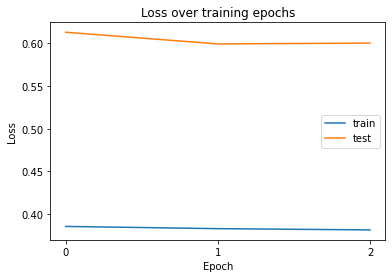

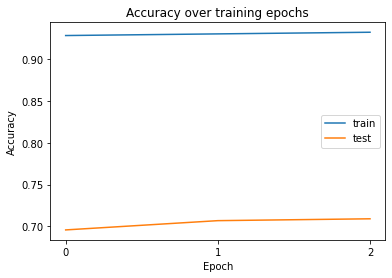

In [18]:
training_inputs = [(16,5), (32,3), (64,3)]
checkpointName = os.path.join("model/", "bert_faq.ckpt")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointName,
                                                 save_weights_only=True,
                                                 verbose=1)
for batch_size, epochs in training_inputs:
    modelTrained = training_set(batch_size, epochs, cp_callback)
    plotLossEpochs(modelTrained)
    plotAccuracyEpochs(modelTrained)


# Evaluation
Lets calculate the final accuracy & recal after the training is completed.

In [19]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("Train Acc", train_acc)
print("validation Acc", test_acc)

sentences = list(test.response)
y_pred = model.predict(data.test_x).argmax(axis=-1)

16/16 [==============================] - 3s 194ms/step - loss: 0.5327 - acc: 0.7740
Train Acc 0.9179999828338623
validation Acc 0.7739999890327454


Print complete classification report.


In [20]:
print(classification_report(data.test_y, y_pred, target_names=classes))

              precision    recall  f1-score   support

     SARCASM       0.76      0.81      0.78       250
 NOT_SARCASM       0.79      0.74      0.77       250

    accuracy                           0.77       500
   macro avg       0.78      0.77      0.77       500
weighted avg       0.78      0.77      0.77       500



Lets draw a confusion matrix for the actual and predicted labels.

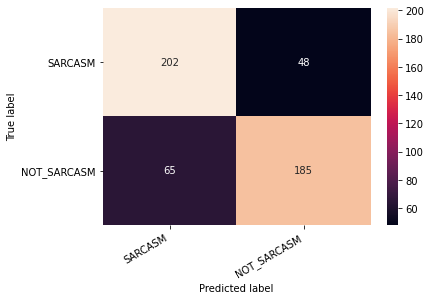

In [21]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');


# Prediction
Sample sentences for our testing.

In [22]:
sentences = [
  "You just broke my car window. Great job.",
  "I sprayed perfume in my eye! I am now a genius",
  "I was depressed. He asked me to be happy. I am not depressed anymore."
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nsarcastic:", classes[label])
  print()

text: You just broke my car window. Great job. 
sarcastic: SARCASM

text: I sprayed perfume in my eye! I am now a genius 
sarcastic: NOT_SARCASM

text: I was depressed. He asked me to be happy. I am not depressed anymore. 
sarcastic: NOT_SARCASM



Lets predict the labels for the list of tweets provided in test list.

In [23]:
sentences = list(map(preprocess_sentence, test.response))
ids = list(test.id)

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)


Get the predict labels for context tweets as well.

In [24]:
sentences_cont = list(map(preprocess_sentence, list(map(lambda tw: tw[len(tw) - 1], test.context))))

pred_cont_tokens = map(tokenizer.tokenize, sentences_cont)
pred_cont_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_cont_tokens)
pred_cont_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_cont_tokens))

pred_cont_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_cont_token_ids)
pred_cont_token_ids = np.array(list(pred_cont_token_ids))

predictions_cont = model.predict(pred_cont_token_ids).argmax(axis=-1)

Generate the answer text for the test file.

In [25]:
for text, label, id, pred_cont, context in zip(sentences, predictions, ids, predictions_cont, sentences_cont):
  label_new = label
  print('{0},{1}'.format(id, classes[label_new], text, pred_cont))

twitter_1,NOT_SARCASM
twitter_2,SARCASM
twitter_3,SARCASM
twitter_4,NOT_SARCASM
twitter_5,SARCASM
twitter_6,SARCASM
twitter_7,NOT_SARCASM
twitter_8,SARCASM
twitter_9,SARCASM
twitter_10,SARCASM
twitter_11,NOT_SARCASM
twitter_12,SARCASM
twitter_13,NOT_SARCASM
twitter_14,NOT_SARCASM
twitter_15,SARCASM
twitter_16,NOT_SARCASM
twitter_17,SARCASM
twitter_18,SARCASM
twitter_19,SARCASM
twitter_20,NOT_SARCASM
twitter_21,NOT_SARCASM
twitter_22,NOT_SARCASM
twitter_23,NOT_SARCASM
twitter_24,SARCASM
twitter_25,SARCASM
twitter_26,NOT_SARCASM
twitter_27,NOT_SARCASM
twitter_28,NOT_SARCASM
twitter_29,SARCASM
twitter_30,NOT_SARCASM
twitter_31,SARCASM
twitter_32,NOT_SARCASM
twitter_33,SARCASM
twitter_34,SARCASM
twitter_35,NOT_SARCASM
twitter_36,SARCASM
twitter_37,SARCASM
twitter_38,SARCASM
twitter_39,SARCASM
twitter_40,NOT_SARCASM
twitter_41,SARCASM
twitter_42,NOT_SARCASM
twitter_43,SARCASM
twitter_44,NOT_SARCASM
twitter_45,NOT_SARCASM
twitter_46,NOT_SARCASM
twitter_47,SARCASM
twitter_48,SARCASM
twitter_4

# Save Trained Model
Save the generated model to a file. which we can use later by loading it from the drive.

In [26]:
!mkdir -p saved_model
model.save('saved_model/my_model')
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 85)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 85, 768)           108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)      

In [27]:
!zip -r /content/myModel.zip /content/saved_model/my_model

  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 80%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 91%)
  adding: content/saved_model/my_model/assets/ (stored 0%)
